# A BERT-based algorithm for edit distance between text trees

This notebook contains the implementation of a simple yet informative metric for text tree comparison. This way of text tree similarity measurement can be used, for example, to compare salient sentence-based mind maps generated by a neural network with reference maps. The way this algorithm works is by applying the Zhang-Shasha algorithm for tree edit distance to text trees, using semantic similarity as the cost of node updates. To measure semantic similarity of sentences in tree nodes, we use a BERT-like language model's embeddings of the sentences, given the context of all parent nodes if available, and compare these embeddings directly.

The Zhang-Shasha algorithm implementation is taken from the `zss` Python library developed by Tim Henderson and Steve Johnson (2013). _[here goes the description of what model we use and how we compare embeddings from it]_. 

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import json
import rouge
import warnings
warnings.filterwarnings("ignore")

import zss
from sentence_transformers import SentenceTransformer

In [2]:
# Plot formatting
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

First, we will slightly extend the `Node` class from `zss` to include depth information in tree nodes. This will later be useful for similarity weight adjustment for nodes of different depth.

In [3]:
class Node(zss.Node):
    def __init__(self, label, children=None, depth=0):
        '''
        Updated version of Node constructor containing self.depth initialization.
        '''
        self.label = label
        self.children = children or list()
        self.depth = depth

    @staticmethod
    def get_depth(node):
        '''
        Method that returns the node's depth field.
        '''
        return node.depth

We will use text trees stored in the JSON format as in the following example:
```json
{
  "A new algorithm for text tree edit distance based on Zhang-Shasha's algorithm and BERT-like model embedding similarity.": {
    "The algorithm's novelty is in its similarity measure based on BERT-like model embeddings.": {
      "Embedding distance is used as a measure of semantic similarity.": {},
      "The language model allows to capture semantic meaning of sentences and model their similarity.": {}
    },
    "Zhang-Shasha's algorithm is used to compute tree edit distance with new edit costs.": {
      "Semantic similarity is used as the update cost in the algorithm.": {},
      "The costs of insertion and removal of nodes are defined as the similarity of the node and an empty sentence.": {}
    },
    "The proposed algorithm is presented as a more informative metric of similarity between text trees.": {
      "The current ways of comparing text trees overlook overlook their tree structure or the meaning of their labels.": {},
      "This new method can be used, for example, to compare mind maps or hierarchical summaries.": {}
    }
  }
}
```
Below is a function that reads a `.json` file with a mind map and converts in to a `Node` tree:

In [4]:
def json_to_node(filename):
    '''
    Reads text tree from JSON file to tree of the Node class.

    Arguments:
    filename: string - name of JSON file with text tree to open.

    Output:
    tree: Node - root node of the tree.
    '''
    with open(filename, 'r') as f:
        json_data = json.load(f)

    # Recursively construct tree from dict data
    def dict_to_node(json_data, depth=0):
        if not json_data:
            return None
    
        # The JSON format has exactly one key-value pair per subtree
        label, children_dict = next(iter(json_data.items()))

        node = Node(label, depth=depth)

        for child_label, child_subtree in children_dict.items():
            child_node = dict_to_node({child_label: child_subtree}, depth=depth+1)
            if child_node:
                node.addkid(child_node)
    
        return node

    tree = dict_to_node(json_data)
    return tree

Also we will need a function to relabel text trees so that each node contains all of the parent nodes' labels a context.

In [5]:
def tree_with_context(input_node: Node):
    '''
    A function that creates a relabeled tree based on the input one by adding sentences from parent nodes as context to child nodes.

    Arguments:
    input_node - root node of the tree to be relabeled.

    Output: 
    Root node of relabeled tree.
    '''
    def add_context(node: Node, context):
        new_node = Node(context + Node.get_label(node), depth=Node.get_depth(node))
        
        for child_node in Node.get_children(node):
            new_node.addkid(add_context(child_node, Node.get_label(new_node)))
        
        return new_node

    return add_context(input_node, "")

To speed the algorithm up, we will implement semantic distance precomputation for Zhang-Shasha's algorithm:

In [6]:
def extract_sentences(tree: Node):
    '''
    A utility function that uses DFS to traverse a tree and extract all of its sentences.

    Arguments:
    tree - a text tree of the type Node.

    Output:
    sentences: list(string) - a list of all the sentences in tree.
    '''
    sentences = [Node.get_label(tree)]
    for child in Node.get_children(tree):
        sentences += extract_sentences(child)

    return sentences
    

def precompute_dists(tree_a: Node, tree_b: Node, encoder, embedding_dist):
    '''
    A helper function to precompute semantic distance between pairs of sentences in two text trees.

    Arguments:
    tree_a, tree_b - two trees of the zss type Node;
    similarity_func - a function of two string arguments which computes sentence distance.
    encoder - a language model's callable encoder that takes string input returns embeddings from the model
    embedding_dist - an embedding similarity measure that takes two embeddings as input and returns a non-negative distance value. 

    Output:
    sentence_dists: dict(dict(string: float)) - a 2-D dict containing scores for each pair of sentences from tree_a and tree_b.
    sentence_weights: dict(string: float) - a dict containing sentence weights (that is, distances to "") for deletion and insertion operation costs
    '''
    sentences_a, sentences_b = extract_sentences(tree_a), extract_sentences(tree_b)
    embeddings_a, embeddings_b = list(encoder(sentences_a)), list(encoder(sentences_b))

    sentence_dists = {}
    for sentence in sentences_a:
        sentence_dists[sentence] = {}

    for sent_a, emb_a in zip(sentences_a, embeddings_a):
        for sent_b, emb_b in zip(sentences_b, embeddings_b):
            sentence_dists[sent_a][sent_b] = embedding_dist(emb_a, emb_b)

    sentence_weights = {}
    empty_emb = encoder("")
    for sent, emb in zip(sentences_a + sentences_b, embeddings_a + embeddings_b):
        sentence_weights[sent] = embedding_dist(emb, empty_emb)

    return sentence_dists, sentence_weights

Finally, we use all the functions above to compute tree distance with `zss.distance`. Note the possible usage of a depth factor to adjust update costs according to the updated node's depth. Our approach can be modified to factor in node depth in a different way.

In [7]:
def text_tree_distance(tree_a: Node, tree_b: Node, encoder, embedding_dist, depth_factor=1.0, use_context=True):
    '''
    The function that calculates tree edit distance between to trees given a similarity function for sentence pairs.
    
    Arguments:
    tree_a, tree_b - two trees of the zss type Node to be compared;
    similarity_func - a function of two string arguments which computes sentence distance;
    depth_factor - a hyperparameter that scales sentence similarity based on the node's depth;
    use_context - a flag indicating whether parents of the given node will be used as context for sentence comparison.

    Output:
    dist: float - the calculated tree edit distance between tree_a and tree_b
    '''
    if use_context:
        tree_a = tree_with_context(tree_a)
        tree_b = tree_with_context(tree_b)

    sentence_dists, sentence_weights = precompute_dists(tree_a, tree_b, encoder, embedding_dist)

    # Here we define the update_cost, insert_cost and delete_cost functions needed for Zhang-Shasha's algorithm using the provided similarity function.
    def update_cost(node_a: Node, node_b: Node):
        return sentence_dists[Node.get_label(node_a)][Node.get_label(node_b)] * depth_factor**Node.get_depth(node_a)

    def insert_cost(node: Node):
        # We define node insertion and deletion costs as similarity of the node's label to an empty string
        return sentence_weights[Node.get_label(node)] * depth_factor**Node.get_depth(node)

    def remove_cost(node: Node):
        return sentence_weights[Node.get_label(node)] * depth_factor**Node.get_depth(node)

    dist = zss.distance(tree_a, tree_b, Node.get_children, insert_cost, remove_cost, update_cost)
    return dist
    

We will also include a version of the `text_tree_distance` function without precomputation to assess the increase in performance that precomputation allows to achieve.

In [8]:
def text_tree_distance_w_o_precomputation(tree_a: Node, tree_b: Node, encoder, embedding_dist, depth_factor=1.0, use_context=True):
    '''
    A modified version of text_tree_distance that doesn't incorporate precomputation.
    It calculates tree edit distance between to trees given a similarity function for sentence pairs.
    
    Arguments:
    tree_a, tree_b - two trees of the zss type Node to be compared;
    similarity_func - a function of two string arguments which computes sentence distance;
    depth_factor - a hyperparameter that scales sentence similarity based on the node's depth;
    use_context - a flag indicating whether parents of the given node will be used as context for sentence comparison.

    Output:
    dist: float - the calculated tree edit distance between tree_a and tree_b
    '''
    if use_context:
        tree_a = tree_with_context(tree_a)
        tree_b = tree_with_context(tree_b)

    def similarity_func(sentence_a, sentence_b):
        a_embedding = encoder(sentence_a)
        b_embedding = encoder(sentence_b)

        return embedding_dist(a_embedding, b_embedding)

    # Here we define the update_cost, insert_cost and delete_cost functions needed for Zhang-Shasha's algorithm using the provided similarity function.
    def update_cost(node_a: Node, node_b: Node):
        return similarity_func(Node.get_label(node_a), Node.get_label(node_b)) * depth_factor**Node.get_depth(node_a)

    def insert_cost(node: Node):
        # We define node insertion and deletion costs as similarity of the node's label to an empty string
        return similarity_func(Node.get_label(node), "")

    def remove_cost(node: Node):
        return similarity_func(Node.get_label(node), "")

    dist = zss.distance(tree_a, tree_b, Node.get_children, insert_cost, remove_cost, update_cost)
    return dist

Below we provide an example use case of the functions above utilizing a model from `sentence_transformers`:

In [10]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')

def cos_dist(a_embedding, b_embedding):
    return float(1 - model.similarity(a_embedding, b_embedding))

In [11]:
A = (
    Node('We present a new metric for text tree comparison.', depth=0)
        .addkid(Node('It uses Zhang-Shasha\'s algorithm and a BERT-like model.', depth=1)
            .addkid(Node('Zhang-Shasha\'s algorithm is used to measure tree edit distance effectively.', depth=2))
            .addkid(Node('The BERT-like model is used to measure semantic similarity.', depth=2)))
        .addkid(Node('The algorithm is presented as an informative metric for text tree comparison.', depth=1)
            .addkid(Node('There hasn\'t yet been a metric that allows to compare tree-structured text data such as mind maps informatively.', depth=2))
            .addkid(Node('This metric can be used, for example, to evaluate automatic salient sentence-based mind map generation.', depth=2)))
)

B = (
    Node('A new metric for text tree comparison based on tree edit distance and semantic similarity.', depth=0)
        .addkid(Node('Zhang-Shasha\'s algorithm is used to compute tree edit distance.', depth=1))
        .addkid(Node('Semantic similarity is measured using a BERT-like language model.', depth=1)
            .addkid(Node('To measure it, the sentences with all parent nodes as context are passed to the language model.', depth=2))
            .addkid(Node('Semantic similarity is measured as the similarity of the model\'s embeddings of the sentences.', depth=2)))
        .addkid(Node('This metric can be used to compare text trees.', depth=1)
            .addkid(Node('For example, it can be utilized in automatic mind map generation evaluation against reference maps.', depth=2)))
)

C = (
    Node('A new algorithm for text tree edit distance based on Zhang-Shasha\'s algorithm and BERT-like model embedding similarity.', depth=0)
        .addkid(Node('The algorithm\'s novelty is in its similarity measure based on BERT-like model embeddings.', depth=1)
            .addkid(Node('Embedding distance is used as a measure of semantic similarity.', depth=2))
            .addkid(Node('The language model allows to capture semantic meaning of sentences and model their similarity.', depth=2)))
        .addkid(Node('Zhang-Shasha\'s algorithm is used to compute tree edit distance with new edit costs.', depth=1)
            .addkid(Node('Semantic similarity is used as the update cost in the algorithm.', depth=2))
            .addkid(Node('The costs of insertion and removal of nodes are defined as the similarity of the node and an empty sentence.', depth=2)))
        .addkid(Node('The proposed algorithm is presented as a more informative metric of similarity between text trees', depth=1)
            .addkid(Node('The current ways of comparing text trees overlook overlook their tree structure or the meaning of their labels.', depth=2))
            .addkid(Node('This new method can be used, for example, to compare mind maps or hierarchical summaries.', depth=2)))
)

Below we compare the versions of `text_tree_distance` with and without precomputation in terms of time performance.

In [12]:
%%time

A_B_dist = text_tree_distance_w_o_precomputation(A, B, model.encode, cos_dist)
A_C_dist = text_tree_distance_w_o_precomputation(A, C, model.encode, cos_dist)
C_B_dist = text_tree_distance_w_o_precomputation(C, B, model.encode, cos_dist)

print(A_B_dist, A_C_dist, C_B_dist)

3.2734222412109375 4.964913785457611 5.261121928691864
CPU times: total: 28.8 s
Wall time: 30.1 s


In [13]:
%%time

AB_dist = text_tree_distance(A, B, model.encode, cos_dist)
AC_dist = text_tree_distance(A, C, model.encode, cos_dist)
CB_dist = text_tree_distance(C, B, model.encode, cos_dist)

print(AB_dist, AC_dist, CB_dist)

3.2734221816062927 4.9649136662483215 5.261122345924377
CPU times: total: 172 ms
Wall time: 187 ms


As can be seen above, precomputation makes the algorithm run an order of magnitude faster. Let's also look at the effect of the depth factor on similarity scores:

In [14]:
A_B_dist_0_7 = text_tree_distance(A, B, model.encode, cos_dist, depth_factor=0.7)
A_B_dist_1_5 = text_tree_distance(A, B, model.encode, cos_dist, depth_factor=1.5)

In [15]:
print(A_B_dist_0_7)
print(A_B_dist_1_5)

2.0180649334192275
6.003455653786659


We will use the similarity metric from "Coherence Graph Guidance for Mind-Map Generation" (Zhang et al., 2024) as a baseline for comaprison. Here is all the code from this paper that we will need (with added comments):

In [16]:
def rouge_sim2(summary, hypothesis):
    '''
    The function that calculates averaged ROUGE similarity between two sentences.
    The similarity score is defined as the mean of ROUGE-1, ROUGE-2 and ROUGE-L, as in Zhang et al., 2024.

    Arguments:
    summary, hypothesis: string - two sentences to be compared.

    Output:
    score: float - sentence similarity score.
    '''
    if summary == []:
        summary = ""
    if hypothesis == []:
        hypothesis = ""
    evaluator = rouge.Rouge()
    r_1 = evaluator.get_scores(hypothesis, summary)[0]['rouge-1']['f']
    r_2 = evaluator.get_scores(hypothesis, summary)[0]['rouge-2']['f']
    r_l = evaluator.get_scores(hypothesis, summary)[0]['rouge-l']['f']
    score = r_1 / 3 + r_2 / 3 + r_l / 3
    return score


def compare_method(pairs1, pairs2):
    '''
    A function that compares two text trees using the above similarity function.

    Arguments:
    pairs, pairs2: list[list[string]] - two text trees in the form of [parent, child] sentence pairs in width-first order.

    Output:
    sim: float - similarity score for the two trees. 
    '''
    pairs = pairs1.copy()
    sim = 0
    for i in range(len(pairs2)):
        msp = ['_', '_']
        found = False
        for j in range(len(pairs)):
            first = rouge_sim2(pairs2[i][0], msp[0]) + rouge_sim2(pairs2[i][1], msp[1])
            second = rouge_sim2(pairs2[i][0], pairs[j][0]) + rouge_sim2(pairs2[i][1], pairs[j][1])
            if first < second:
                msp = pairs[j]
                max_index = j
                found = True

        cur_sim_0 = rouge_sim2(pairs2[i][0], msp[0])
        cur_sim_1 = rouge_sim2(pairs2[i][1], msp[1])
        sim = sim + (cur_sim_0 + cur_sim_1) / 2

        if found:
            del pairs[max_index]
    return sim

To work with the functions above, we will need to transform text trees made out of `Node` nodes to pairs of `[parent, child]` sentences in width-first order:

In [17]:
def tree_to_pairs(tree: Node):
    '''
    Function that transforms Node tree to array of parent-child pairs.

    Arguments:
    tree: Node - input tree of the Node class.

    Output:
    pairs: list[list[string]] - list of pairs of parent-child node labels in width-first order.
    '''
    pairs = []
    for child in Node.get_children(tree):
        pairs.append([Node.get_label(tree), Node.get_label(child)])
    for child in Node.get_children(tree):
        pairs += tree_to_pairs(child)

    return pairs

Finally, we combine all the functions above into one:

In [18]:
def baseline_distance(tree_a: Node, tree_b: Node):
    '''
    Function that scores tree distance using the baseline method. 
    For concreteness we use the negative of the similarity score, since our method estimates distance rather than similarity.

    Arguments:
    tree_a, tree_b: Node - trees to be compared.

    Output:
    dist: float - distance score between the input trees.
    '''
    pairs_a, pairs_b = tree_to_pairs(tree_a), tree_to_pairs(tree_b)

    sim = compare_method(pairs_a, pairs_b)
    dist = -sim

    return dist

Now we can run a couple of experiments to evaluate these two metrics on simple test cases. We will compare the methods on three text tree sets, each based on the tree `C` from the example above:
1) A set of trees that are identical in semantic meaning and structure, but the sentences in the tree nodes are paraphrased;
2) A set of trees that are formed from the same sentences, but in different tree order;
3) A set of trees that are similar in structure and wording but significantly different in meaning.

For each set of trees we compute pairwise similarity scores with our metric and the baseline method. The goal is to capture the difference in meaning and structure of the trees while minimizing the distance between trees that are, in a sense, paraphrases of each other.

In [31]:
scores = {}
baseline_scores = {}

test_cases = ['paraphrase', 'restructure', 'meaning']

for test_case in test_cases:
    path = 'data/' + test_case + '/' + test_case + '_'
    scores[test_case] = []
    baseline_scores[test_case] = []

    trees = []
    for i in range(5):
        trees.append(json_to_node(path + str(i) + '.json'))

    for i in range(4):
        for j in range(i, 5):
            scores[test_case].append(text_tree_distance(trees[i], trees[j], model.encode, cos_dist, use_context=True))
            baseline_scores[test_case].append(baseline_distance(trees[i], trees[j]))

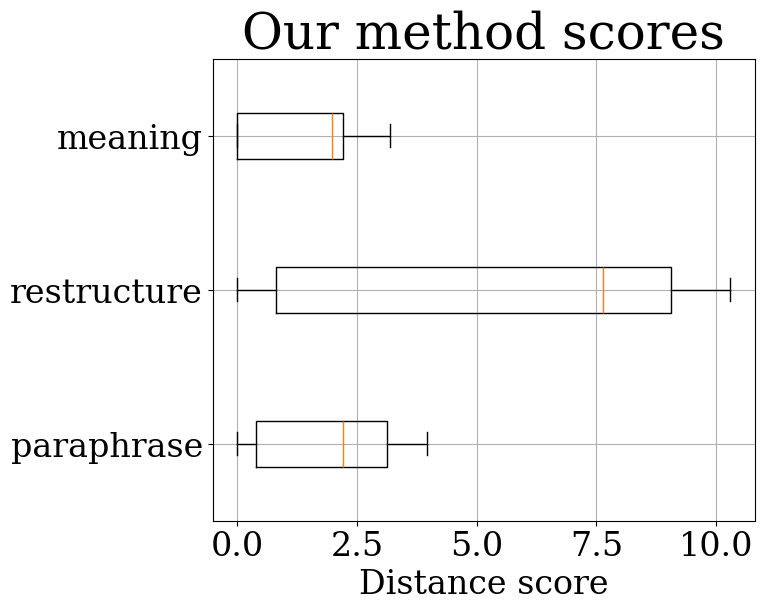

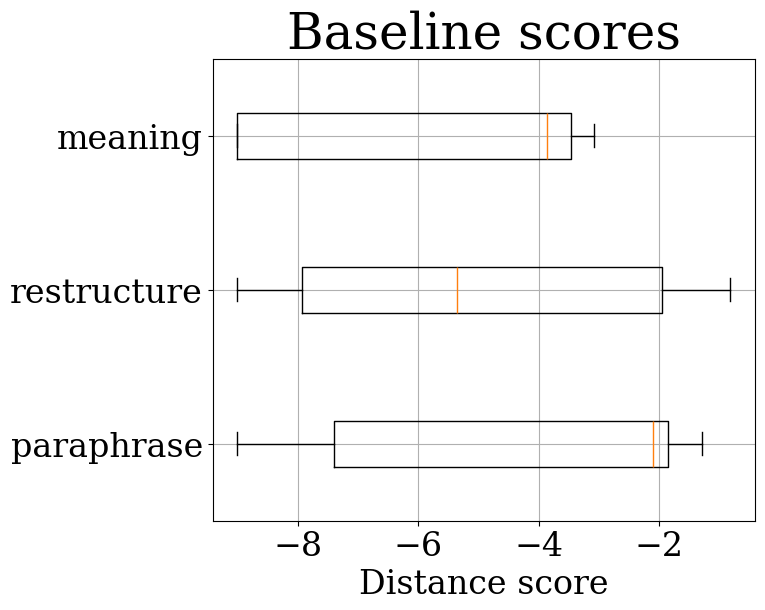

In [32]:
fig1, ax1 = plt.subplots(figsize=(7, 6))
fig2, ax2 = plt.subplots(figsize=(7, 6))

ax1.boxplot(scores.values(), vert=False)
ax2.boxplot(baseline_scores.values(), vert=False)

for ax in (ax1, ax2):
    ax.set_xlabel('Distance score')
    ax.set_yticklabels(scores.keys())
    ax.grid()

ax1.set_title('Our method scores')
ax2.set_title('Baseline scores')

fig1.savefig('../img/results.png', bbox_inches='tight', pad_inches=0.1)
fig2.savefig('../img/baseline_results.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

Below are also the numerical results of the experiment:

In [26]:
results_array = []
for exp in ('paraphrase', 'restructure', 'meaning'):
    results_array.append([exp, np.mean(baseline_scores[exp]), np.std(baseline_scores[exp]), np.mean(scores[exp]), np.std(scores[exp])])

results_frame = pd.DataFrame(results_array, columns=['Experiment', 'Baseline mean', 'Baseline std', 'Our mean', 'Our std'])

print(results_frame)

    Experiment  Baseline mean  Baseline std  Our mean   Our std
0   paraphrase      -3.945266      3.211650  1.946627  1.372653
1  restructure      -5.137458      3.004534  5.751190  4.024386
2      meaning      -5.547937      2.600850  1.430003  1.105409
